# Setup

In [1]:
import sys
sys.path.append('/mnt/c/Users/Arnisa/Desktop/MP/mp-tl-study')
from functions.visualization_utils import *

## Load Data

In [5]:
# load baselines: filename!!
with open('results/baselines_freeze_True_pool_True_lr_0.001_truncate.json', 'r') as f:
    baselines = json.load(f)
baselines = baselines[1:]

# load results; filename
with open('results/results_freeze_True_reinit_False_pool_True_truncated.json', 'r') as f:
    results = json.load(f)

# Run this if the first element of the results is the PARAMS dict
params = results[0]
results = results[1:]
# if not, initialize a params dict -see 3. Init params

data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.000,0.202267
1,0.001,0.001,-1,1,0.875,0.197400
2,0.001,0.001,-1,2,0.875,0.208900
3,0.001,0.001,-1,3,1.000,0.176700
4,0.001,0.001,-1,4,1.000,0.232567


In [6]:
# Filter the baselines to these percentages: 0.001, 0.01, 0.1, 0.5, 1.0
# because there are some extra percentages
baselines = [result for result in baselines if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]

results = [result for result in results if result["sampled_percentage"] in [0.001, 0.01, 0.1, 0.5, 1.0]]
data_dicts = baselines + results 
# Create DataFrame from the list of dictionaries
df = pd.DataFrame(data_dicts)

# Rename the columns to match the specified names
df.rename(columns={
    'lr': 'learning rate',
    'sampled_percentage': 'Percentage',
    'sampled_cut_point': 'Cut Point',
    'repeat': 'Trial',
    'train_acc': 'Train Accuracy',
    'test_acc': 'Test Accuracy'
}, inplace=True)

# Display the DataFrame (showing the first few rows for brevity)
df.head()

,learning rate,Percentage,Cut Point,Trial,Train Accuracy,Test Accuracy
0,0.001,0.001,-1,0,1.000,0.202267
1,0.001,0.001,-1,1,0.875,0.197400
2,0.001,0.001,-1,2,0.875,0.208900
3,0.001,0.001,-1,3,1.000,0.176700
4,0.001,0.001,-1,4,1.000,0.232567


In [33]:
# OR LOAD ARI Scores
"""with open("results_jsons/ari/ari_scores_finetuned_Fashion_to_MNIST.json", "r") as f:
    ari_scores_all = json.load(f)
df_ari = pd.DataFrame(ari_scores_all)

# Display the DataFrame (showing the first few rows for brevity)
df_ari.head()"""

# 1. The plots
See the documentation (mp-tl-study/example_visualizations.ipynb) for a full list of supported visualizations

### Experimental Plots

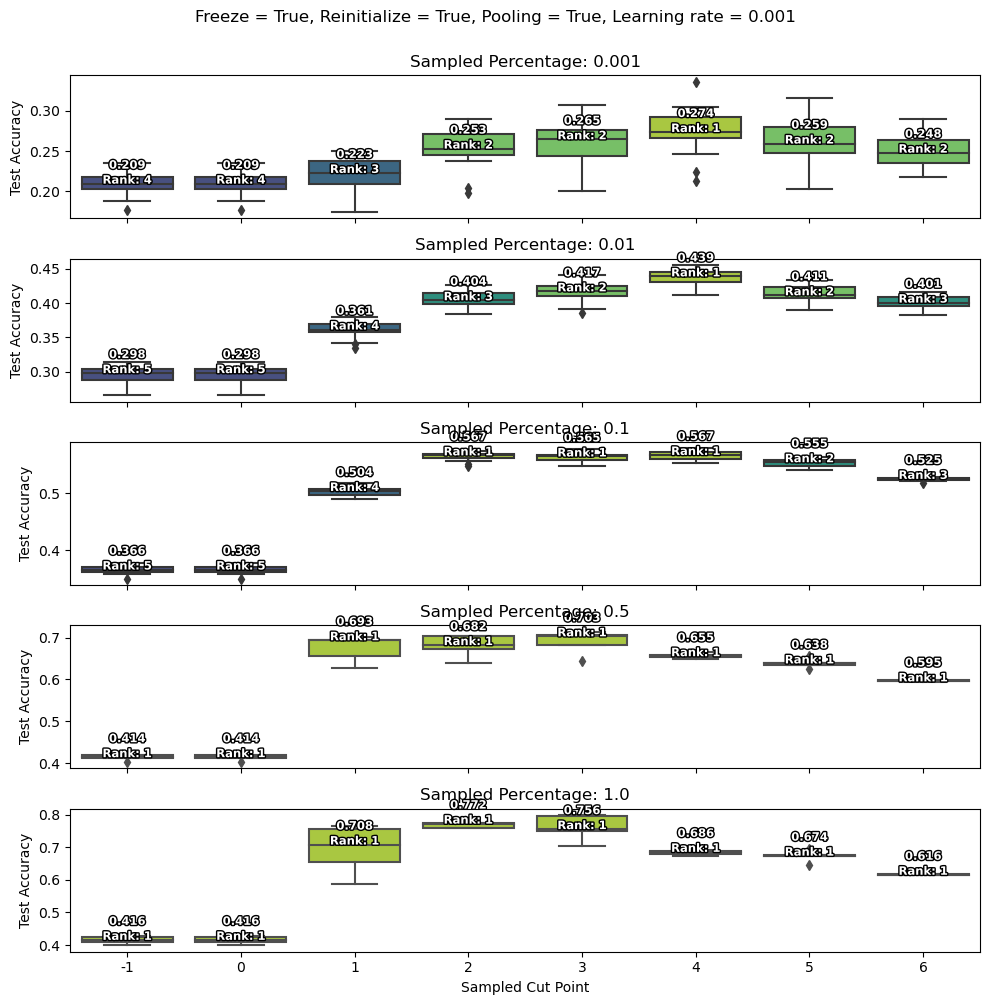

In [7]:
# run statistical tests below to get the df_rankings
df_rankings = pairwise_comparison(df=df)
ranks_sorted = box_plot_percentages_experiments(df=df, rank_df=df_rankings, color_ranks=True, params=params)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

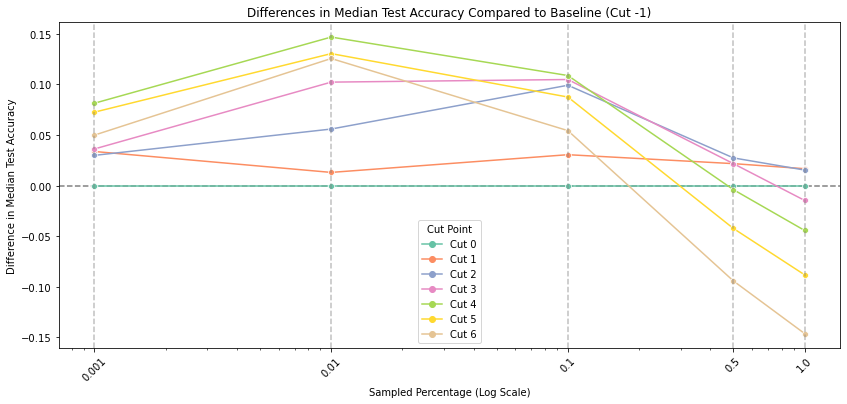

In [9]:
compare_to_baseline_line_plot(df)

<module 'matplotlib.pyplot' from '/opt/anaconda/lib/python3.7/site-packages/matplotlib/pyplot.py'>

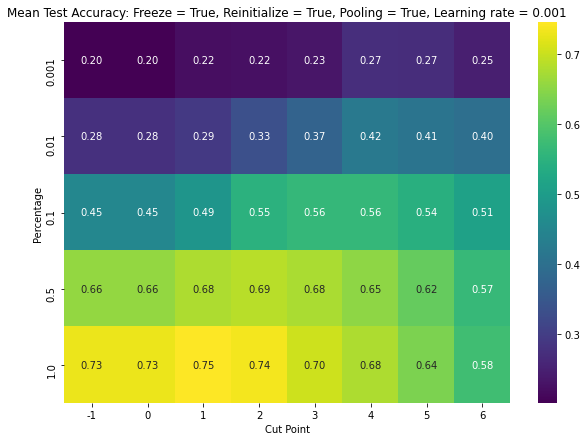

In [10]:
heatmap(df, params, figsize=(10,7))

# 2. Statistical Tests

### Ranking Cuts

In [283]:
from scipy.stats import wilcoxon



/home/arnisa/anaconda3/lib/python3.11/site-packages/scipy/stats/_morestats.py:4088: UserWarning: Exact p-value calculation does not work if there are zeros. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


,Percentage,Cut Point,rank,median_accuracy
0,0.001,0,7,0.196333
1,0.001,1,4,0.230000
2,0.001,2,4,0.226167
3,0.001,3,4,0.232500
4,0.001,4,1,0.277667
5,0.001,5,1,0.268833
6,0.001,6,3,0.246167
7,0.010,0,7,0.275167
8,0.010,1,6,0.288167
9,0.010,2,5,0.331000
